# Plot Neural Manifolds

# Setup

In [1]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json

import default_config as config
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import train
import viz

import neuralgeom.datasets.utils as utils
import neuralgeom.models.neural_vae as neural_vae

INFO:root:Using pytorch backend


# Get config for the run of interest

In [6]:
run_id = "224b786b"
expt = "41"

CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)

Config in directory: /home/nmiolane/code/neuralgeom/neuralgeom/results/configs:
run_224b786b_experimental_41_gain_1.json


Use this for expt 34, whose config was not recorded:

In [7]:
# config_dict = {
#     "batch_size": 4,
#     "decoder_depth": 10,
#     "decoder_width": 200,
#     "encoder_depth": 5,
#     "encoder_width": 50,
#     "lr": 0.0002751022718020967,
#     "dataset_name": "experimental",
#     "sweep_name": "experimental_34_gain_1",
#     "expt_id": "34",
#     "timestep_microsec": 100000,
#     "smooth": True,
#     "select_gain_1": True,
#     "n_times": None,
#     "embedding_dim": None,
#     "distortion_amp": None,
#     "noise_var": None,
#     "manifold_dim": 1,
#     "latent_dim": 2,
#     "posterior_type": "hyperspherical",
#     "distortion_func": None,
#     "n_wiggles": None,
#     "radius": None,
#     "major_radius": None,
#     "minor_radius": None,
#     "synthetic_rotation": None,
#     "device": "cuda",
#     "log_interval": 20,
#     "checkpt_interval": 20,
#     "scheduler": False,
#     "n_epochs": 150,
#     "alpha": 1.0,
#     "beta": 0.03,
#     "gamma": 30,
#     "sftbeta": 4.5,
#     "gen_likelihood_type": "gaussian",
#     "gain": 1,
#     "run_name": "run_87d52ebd_experimental_34_gain_1",
#     "results_prefix": "run_87d52ebd_experimental_34_gain_1",
#     "data_n_times": 8327,
#     "data_dim": 40,
# }

Use this if a config file is present:

In [13]:
with open(
    os.path.join(CONFIG_DIR, f"run_{run_id}_experimental_{expt}_gain_1.json"),
    "r",
) as f:
    config_dict = json.load(f)

In [14]:
# HACK-ALERT: we need to manually add elements to the config
# These are new parameters that have been added to default_config since this run.

if "batch_shuffle" not in config_dict:
    config_dict["batch_shuffle"] = True
if "n_grid_points" not in config_dict:
    config_dict["n_grid_points"] = 100
if "gamma_moving" not in config_dict:
    config_dict["gamma_moving"] = 0
if "gamma_dynamic" not in config_dict:
    config_dict["gamma_dynamic"] = 0
if "drop_out_p" not in config_dict:
    config_dict["drop_out_p"] = 0


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

{'batch_size': 2,
 'decoder_depth': 20,
 'decoder_width': 300,
 'encoder_depth': 2,
 'encoder_width': 50,
 'lr': 0.00257005557147281,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_41_gain_1',
 'expt_id': '41',
 'timestep_microsec': 100000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 150,
 'alpha': 1.0,
 'beta': 0.03,
 'gamma': 30,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': 'run_224b786b_experimental_41_gain_1',
 'results_prefix': 'run_224b786b_experimental_41_gain_1',
 'data_n_times': 828,
 'data_dim': 12,
 'batch_shuffle': True,
 'n_grid_points':

# Get data and curvature profile

### Inspect data (recordings) for outliers

In [15]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_times_timestep100000.txt! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep100000.npy! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_labels_timestep100000.txt! Loading...


The dataset transitions between two gains: 1.769000 and 1.000000.
We select gain 1: gain = 1.
Dataset shape: (828, 12).


We plot the histogram of the values in the original dataset, to see if there are outliers.

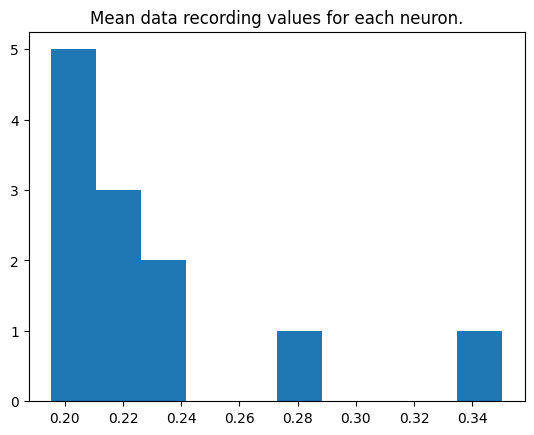

In [16]:
plt.hist(dataset_torch.mean(axis=0).cpu().numpy())
plt.title("Mean data recording values for each neuron.");

### Inspect curvature norms for outliers and filter

We filter the data to remove very high curvatures

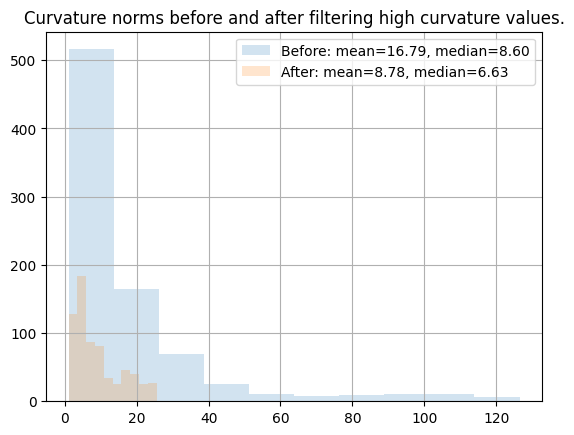

In [17]:
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

curv_norm_learned_profile = pd.read_csv(
    os.path.join(
        CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"
    )
)

median = curv_norm_learned_profile["curv_norm_learned"].median()
filtered = curv_norm_learned_profile[
    curv_norm_learned_profile["curv_norm_learned"] < 3 * median
]

fig, ax = plt.subplots(1, 1)

mean = curv_norm_learned_profile["curv_norm_learned"].mean()
median = curv_norm_learned_profile["curv_norm_learned"].median()
label = f"Before: mean={mean:.2f}, median={median:.2f}"
curv_norm_learned_profile["curv_norm_learned"].hist(
    ax=ax, color="C0", label=label, alpha=0.2
)

mean = filtered["curv_norm_learned"].mean()
median = filtered["curv_norm_learned"].median()
label = f"After: mean={mean:.2f}, median={median:.2f}"
filtered["curv_norm_learned"].hist(ax=ax, color="C1", label=label, alpha=0.2)
ax.legend()
ax.set_title("Curvature norms before and after filtering high curvature values.");

# Study curvature and rat's velocity

### Plot neural manifolds (color=velocity)

The neural manifold shows the **inverse** of the curvature, i.e. is a visualization of the shape of the actual manifold.

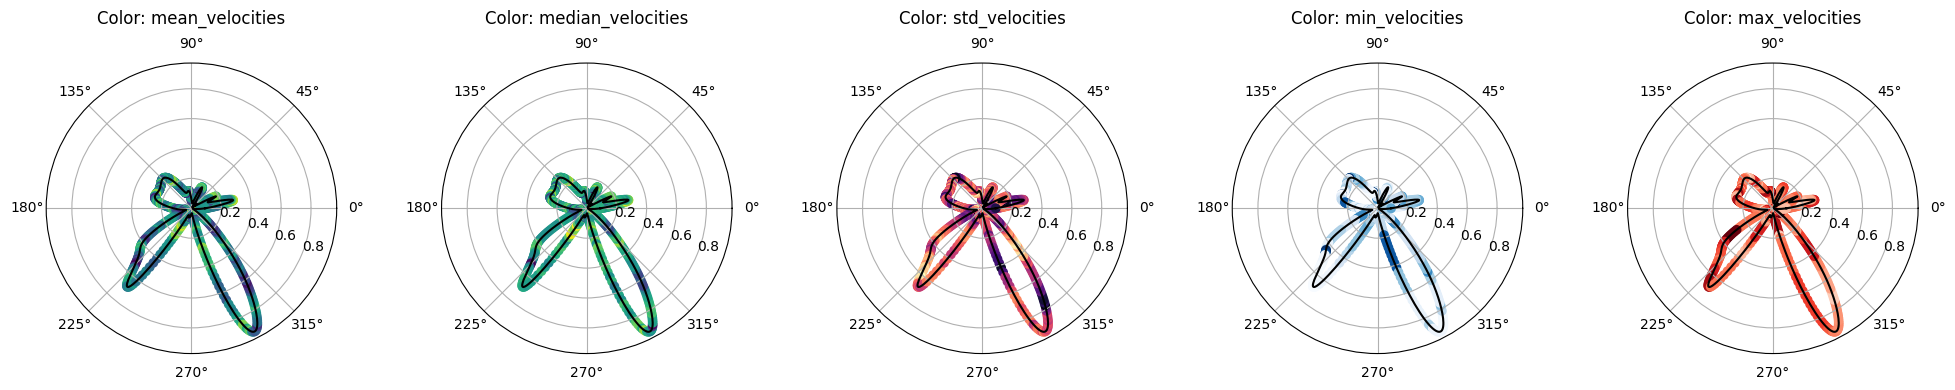

In [18]:
# Without removing high curvature values
viz.plot_neural_manifold_learned(curv_norm_learned_profile, config, labels);

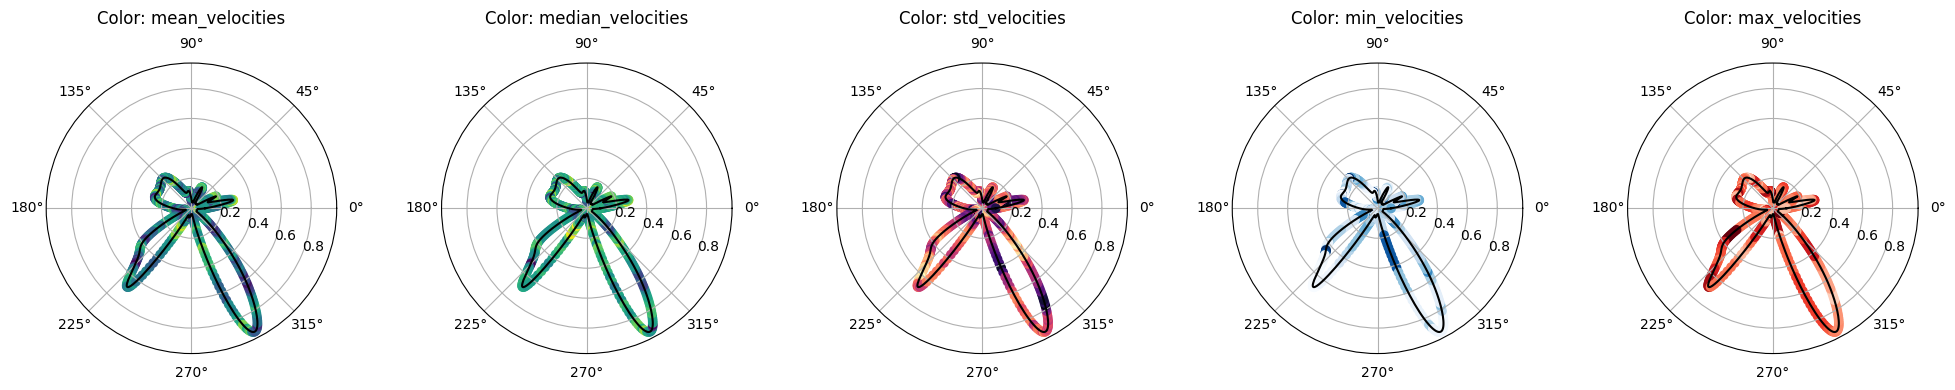

In [19]:
# With filter: i.e., removing high curvature values
viz.plot_neural_manifold_learned(filtered, config, labels);

We cannot really see any difference between the filtered and non-filtered, because high curvatures mean neural manifold's radius close to 0, and everything is collapsed at 0.

### Correlation between curvature and velocity

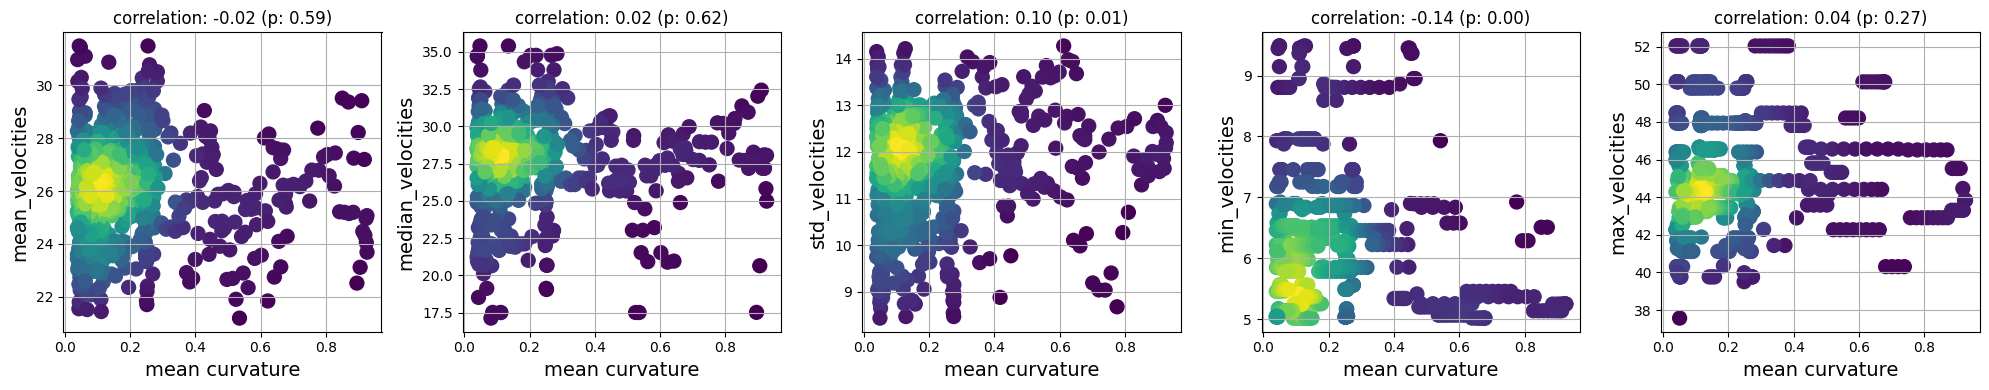

In [20]:
from scipy.stats import gaussian_kde, pearsonr

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(nrows=1, ncols=len(stats), figsize=(20, 4))
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    x = 1 / filtered["curv_norm_learned"]
    y = filtered[stat_velocities]
    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.set_xlabel("mean curvature", fontsize=14)
    ax.scatter(x, y, c=z, s=100)
    ax.grid(True)
    ax.set_ylabel(stat_velocities, fontsize=14)
    pears = pearsonr(x, y)
    # print(pears.statistic)
    ax.set_title(f"correlation: {pears.statistic:.2f} (p: {pears.pvalue:.2f})")
fig.tight_layout()

# Study curvature and neural activations

### Plot recorded and recontructed activations

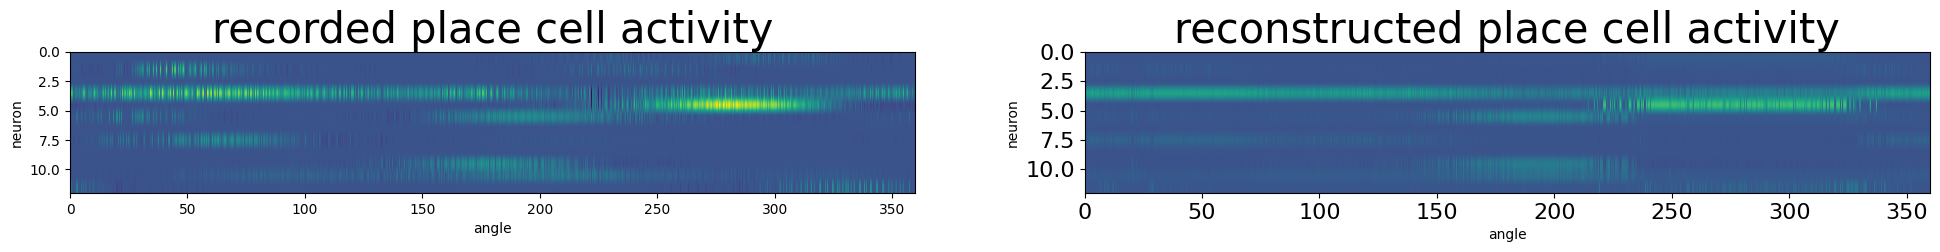

In [21]:
import default_config

model_path = os.path.join(
    default_config.trained_models_dir, f"{config.results_prefix}_model.pt"
)
model = torch.load(model_path)

viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config);

### Plot neural manifolds (color=activation)

Get dataset and reconstructed dataset sorted by angles.

In [22]:
thetas = np.array(labels["angles"])
sort = np.argsort(thetas)
dataset = dataset_torch.cpu().detach().numpy()
sorted_dataset = dataset[sort, :]

_, rec, _ = model(dataset_torch)
rec = rec.cpu().detach().numpy()
sorted_rec = rec[sort, :]

In [23]:
len(curv_norm_learned_profile)

828

In [24]:
def plot_neural_manifold_learned_activations(show_recon=True, single_norm=True, nrows=2):
    """Plot neural manifold colored by activations of neurons.

    Parameters
    ----------
    show_recon : bool
        If True, color with true activation.
        If False, color with reconstructed activation.
    single_norm : bool
        Normalization type for the color map.
        If True, use the maximum activation for each neuron.
        If False, use the maximum activation across neurons.
    """
    _, n_neurons = dataset_torch.shape

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=n_neurons // nrows,
        figsize=(20, 4 * nrows),
        subplot_kw={"projection": "polar"},
    )
    color_norm = mpl.colors.Normalize(0.0, np.max(sorted_dataset))
    activations = sorted_dataset
    if show_recon:
        activations = sorted_rec

    for i in range(n_neurons):
        if single_norm:
            color_norm = mpl.colors.Normalize(0.0, np.max(sorted_dataset[:, i]))
        ax = axes[i % nrows, i // nrows]
        ax.scatter(
            curv_norm_learned_profile["z_grid"][1::15],  ## taking a fithteenth of the entries: change to have more points on the manifold
            1 / curv_norm_learned_profile["curv_norm_learned"][1::15],
            c=activations[1::15, i],
            cmap="viridis",
            norm=color_norm,
        )
        ax.set_rticks([1])  # Less radial ticks
        ax.set_rlabel_position(0)  # Move radial labels away from plotted line
        ax.grid(True)
        ax.set_title("Color: neuron" + str(i), va="bottom")
    fig.tight_layout()
    fig.savefig(
        f"notebooks/figures/run_{run_id}_show_recon_{show_recon}_single_norm_{single_norm}_neural_manifold.svg"
    )

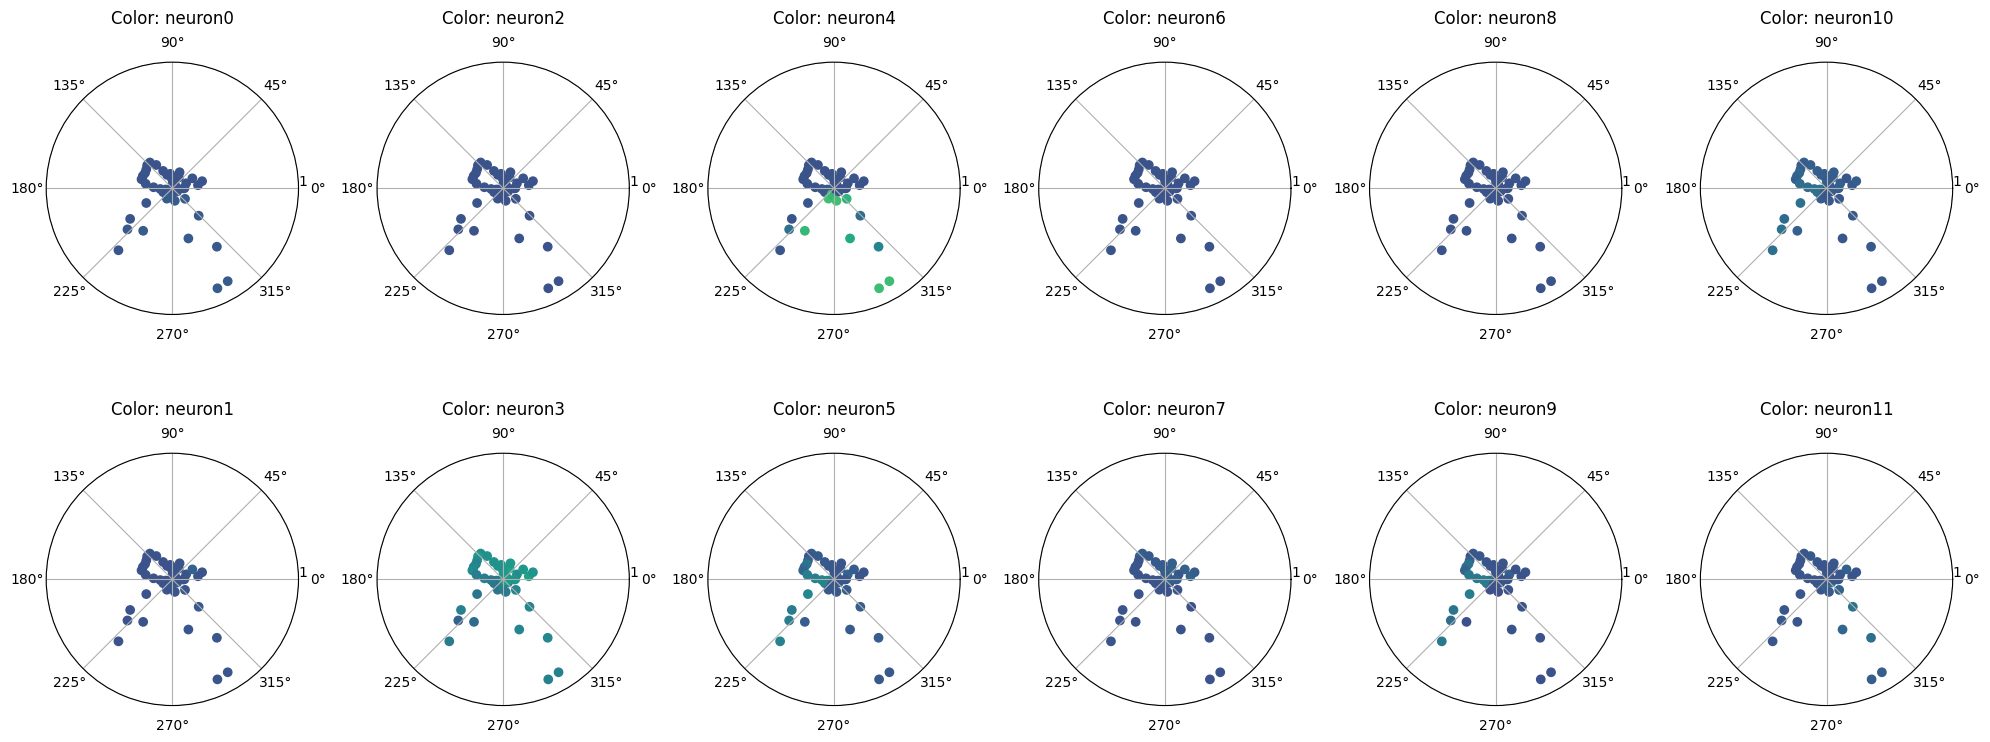

In [27]:
plot_neural_manifold_learned_activations(show_recon=True, single_norm=False, nrows=2)

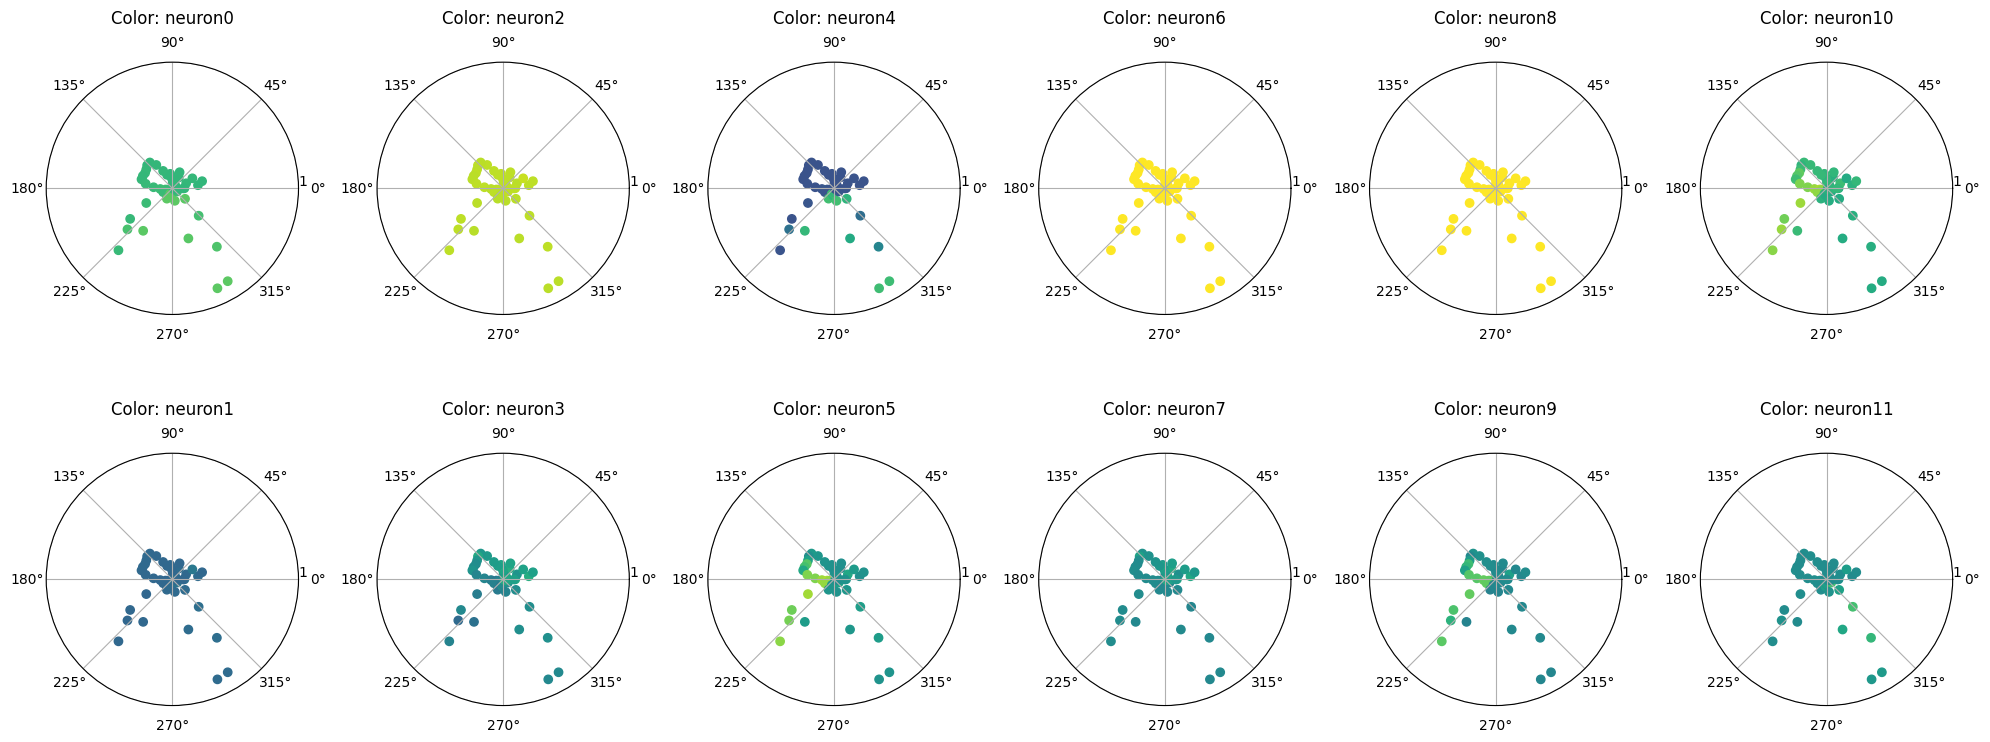

In [28]:
plot_neural_manifold_learned_activations(show_recon=True, single_norm=True, nrows=2)

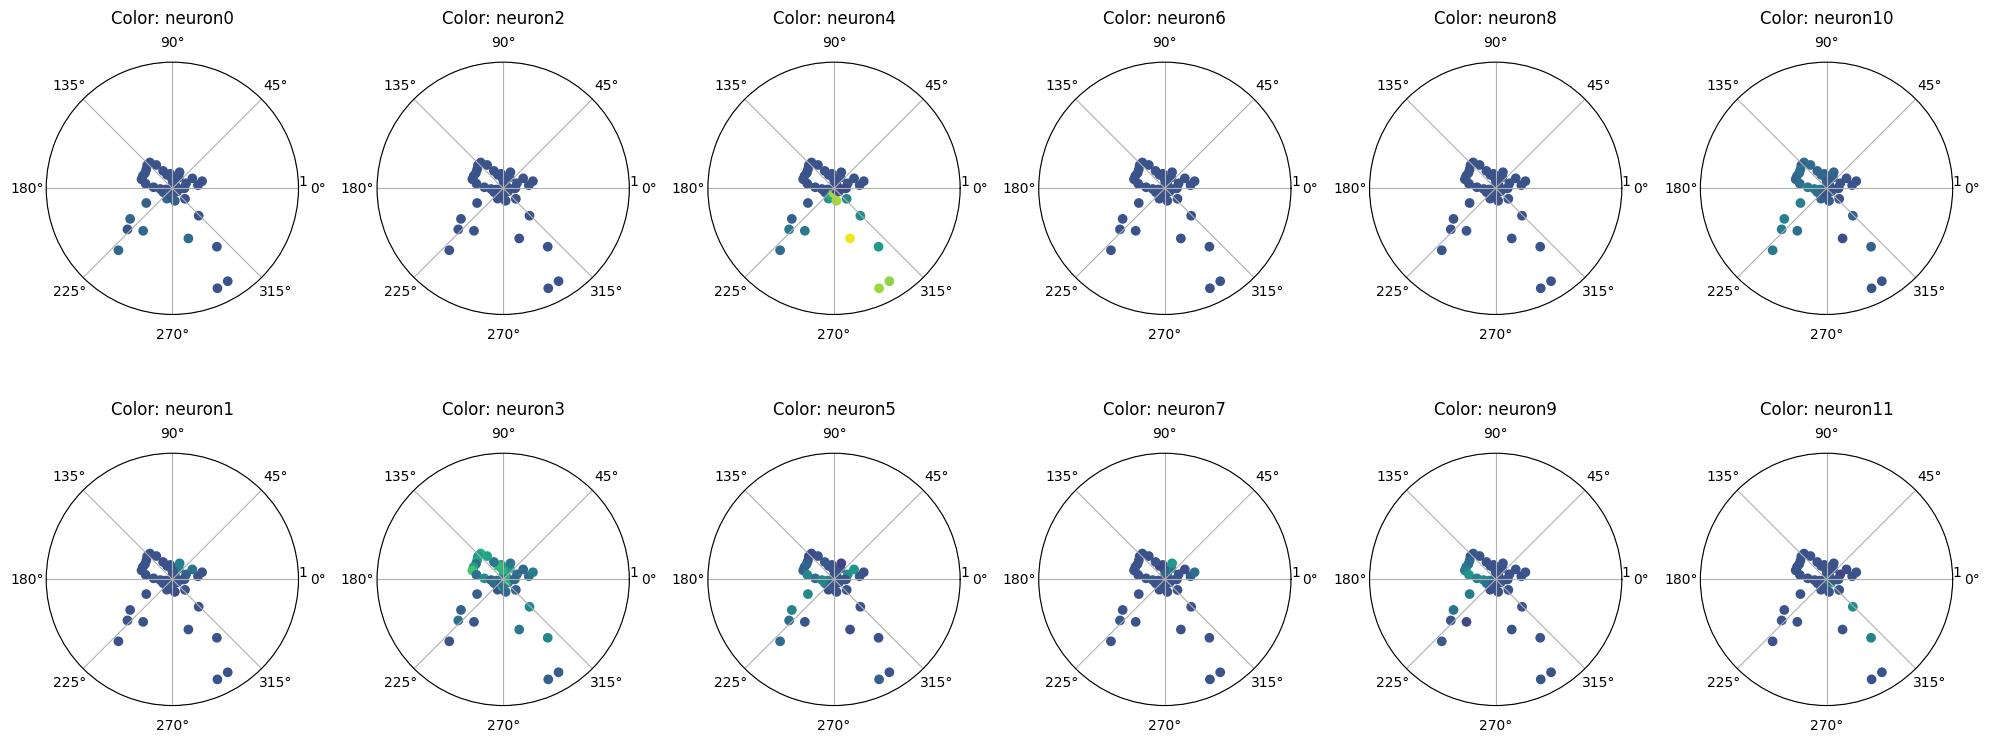

In [29]:
plot_neural_manifold_learned_activations(show_recon=False, single_norm=False, nrows=2)

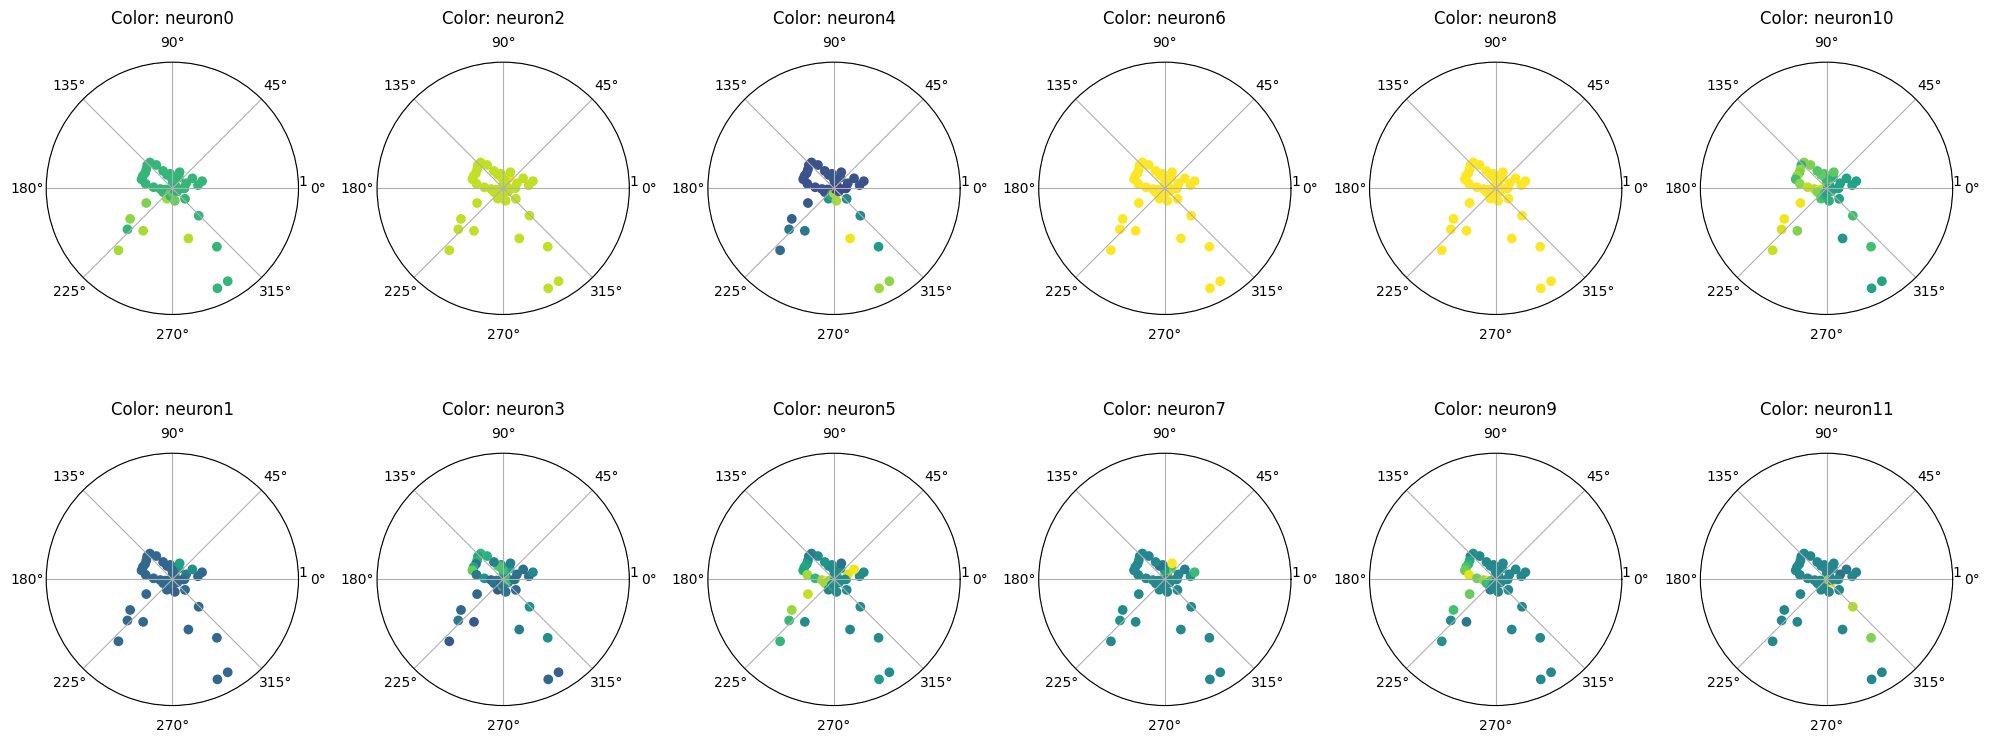

In [30]:
plot_neural_manifold_learned_activations(show_recon=False, single_norm=True, nrows=2)

# Towards Parameterization invariance

The neural manifold shows the **inverse** of the curvature, i.e. is a visualization of the shape of the actual manifold.

We use the geodesic distance on S1 to plot the neural manifold, so that the visualization is reparameterization invariant.

In [31]:
curv_norm_learned_profile

,Unnamed: 0,z_grid,curv_norm_learned,mean_velocities,median_velocities,std_velocities,min_velocities,max_velocities
0,0,0.000000,10.959535,28.007938,29.000062,12.955958,5.014975,50.128431
1,1,0.007598,10.419145,26.778218,29.000062,12.122488,5.014975,50.128431
2,2,0.015195,9.907603,26.458275,29.000062,12.356966,5.014975,50.128431
3,3,0.022793,9.422745,25.228169,28.338400,12.310073,5.014975,50.128431
4,4,0.030390,8.962595,25.996049,28.572700,11.852831,5.014975,50.128431
...,...,...,...,...,...,...,...,...
823,823,6.252795,13.459872,26.620953,29.392455,10.334597,6.532043,41.839952
824,824,6.260393,12.778408,25.793157,28.296476,10.239522,6.532043,41.114120
825,825,6.267990,12.136495,26.630312,30.185731,10.261803,6.532043,41.114120
826,826,6.275588,11.531131,26.675709,28.572392,9.909626,6.532043,41.114120


We will add a column to the dataframe, that records the geodesic distance from a reference z0, chosen to be the first element of the grid.

We first load the model of that run to get the learned immersion.

In [33]:
import time

import evaluate
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=1, embedding_dim=config.data_dim, immersion=learned_immersion
)

## Decide for optimal computations of geodesic distance

Commpare which option is faster.

1. Everything on cuda --> bugs in geomstats.

In [ ]:
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z_grid = z_grid.to("cuda:0")
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(next(model.parameters()).device)
print(z_grid.device)
print(z0.device)

geodesic_dist = gs.zeros(len(z_grid))
print(f"z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:2]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        print(z.device)
        start = time.time()
        dist = neural_metric.dist(z0, z)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Device for dist: {dist.device}")
        geodesic_dist[i_z] = dist

2. Everything on cpu  --> bugs in geomstats.

In [ ]:
model.to("cpu")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(next(model.parameters()).device)
print(z_grid.device)
print(z0.device)

geodesic_dist = gs.zeros(len(z_grid))
print(f"z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:2]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        print(z.device)
        start = time.time()
        dist = neural_metric.dist(z0, z)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Device for dist: {dist.device}")
        geodesic_dist[i_z] = dist

3. Some gpu and some cpu.

We use the parameter n_steps to regulate how precise the computation of the distance is.


TODO: compute the distance between neighboring points so that the exp / log integration are more stable.

In [34]:
model.to("cuda:0")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(f"Model:{next(model.parameters()).device}")
print(f"Zgrid: {z_grid.device}")
print(f"Z0: {z0.device}\n")

geodesic_dist = gs.zeros(len(z_grid))
print(f"Starting for loop: z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:3]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        z_previous = torch.unsqueeze(z_grid[i_z - 1], dim=0)
        print(f"Z: {z.device}")
        print(f"Zprevious: {z.device}")
        start = time.time()
        # Tricks to speed up this computation:
        # 1. Compute with less number of steps for the integration of the geodesic eqn
        # 2. Compute distance between neighboring z's
        dist = neural_metric.dist(z_previous, z, n_steps=10)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Dist: {dist.device}")
        geodesic_dist[i_z] = dist

Model:cuda:0
Zgrid: cpu
Z0: cpu

Starting for loop: z_grid.shape = torch.Size([828])
Grid point id: 0
Grid point id: 1
Z: cpu
Zprevious: cpu
Time: 5.133
Dist: cpu
Grid point id: 2
Z: cpu
Zprevious: cpu
Time: 5.149
Dist: cpu


## Parallel computations of geodesic distances

Let's parallelize this.

In [ ]:
import copy
import logging

from joblib import Parallel, delayed

model.to("cuda:0")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z, z, grid_interval):
    if i_z == 0:
        return (0, torch.tensor(0.0))
    # Parallelize on gpus: is that line really helping,
    # i.e. is the copy taking less time than the computation? if not, don't bother
    # also: does it change anything since neural metric has already been computed and uses the old version of model?
    model_copy = copy.deepcopy(model).to(f"cuda:{i_z % 9}")
    z = torch.unsqueeze(z, dim=0)
    z_previous = torch.unsqueeze(z_grid[i_z - grid_interval], dim=0)
    start = time.time()
    # Tricks to speed up this computation:
    # 1. Compute with less number of steps for the integration of the geodesic eqn
    # 2. Compute distance between neighboring z's
    dist = neural_metric.dist(z_previous, z, n_steps=7)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z}): {duration:.3f}")
    return (i_z, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval = 1
res = Parallel(n_jobs=-1)(
    delayed(_geodesic_dist)(i_z, z, grid_interval)
    for i_z, z in enumerate(z_grid)
    if i_z % grid_interval == 0
)

In [ ]:
geodesic_dists = torch.zeros(len(res))
curv_norms = torch.zeros(len(res))
for i_z, dist in res:
    geodesic_dists[i_z] = dist
    curv_norms[i_z] = curv_norm_learned_profile["curv_norm_learned"].values[i_z]

print(geodesic_dists[:10])
print(curv_norms[:10])
print(1 / curv_norms[:10])

print(len(geodesic_dists))

In [ ]:
cumul_geodesic_dists = torch.cumsum(geodesic_dists, dim=0)
cumul_geodesic_dists[:10]
print(cumul_geodesic_dists.max())

## Plot invariant neural manifold (colored)

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(
    nrows=len(stats), ncols=1, figsize=(20, 20), subplot_kw={"projection": "polar"}
)

i_zs = [i_z for i_z, _ in res]
subgrid_profile = curv_norm_learned_profile  # .take(i_zs)
print(len(subgrid_profile))

for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    ax.scatter(
        cumul_geodesic_dists,
        1 / curv_norms,
        c=subgrid_profile[stat_velocities],
        cmap=cmaps[i_stat],
    )
    ax.plot(
        cumul_geodesic_dists,
        1 / curv_norms,
        c="black",
    )
    # ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()

## Plot invariant neural manifold (uncolored)

In [ ]:
closed_geodesic_dists = torch.concat(
    [cumul_geodesic_dists, torch.tensor([cumul_geodesic_dists[0]])]
)
closed_curv_norms = torch.concat([curv_norms, torch.tensor([curv_norms[0]])])

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6), subplot_kw={"projection": "polar"}
)

i_zs = [i_z for i_z, _ in res]
subgrid_profile = curv_norm_learned_profile.take(i_zs)

ax.plot(closed_geodesic_dists, 1 / closed_curv_norms, c="black")
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()
# import os
# print(os.getcwd())
fig.savefig(f"notebooks/figures/run_{run_id}_invariant_manifold.svg")

Note: this looping is weird, and the geodesic distances go well over 14, i.e. over 3.14*2 which is 2 pi. There must be an error.